# DATA SELECTION SCRIPT for team PYRE-ATES!

***The very short explanation of what this script does***

This script gets the data we want from IBM PAIRS and puts it in a more familiar csv format in a google drive directory.

The data we want for a given area:
- vegetation at the start of the fire season 'vegetation_first'
- burned area at the end of the fire season 'burns_aggregated'.

The script is based on the IBM example 'Calling PAIRS API with Watson Studio' provided on the github.

*** CHOICE OF DATA ***

In the end we want this data to inform a model that takes the previous fire history & vegetation from an area to predict which areas are at risk in the coming fire season. Obviously there are more data available but given time constraints and different data types we stuck with MODIS satellite data, which is available globally across the past two decades. For a time series model we really needed data from many years, and there aren't significant fire events every year. Some pairs datasets only have data from a few years, or don't have coverage of the areas we were interested in. 

There is other NASA FIRMS data available, which contains information about fire hotspots and is in a vector format. This proved extremely time consuming / difficult to download so we stuck with the lower resolution MODIS burned area data instead, which is in raster form.

We chose locations with known significant fire activity across the last decade or so. We sample two different locations with two _VERY DIFFERENT_ wildfire regimes:
- ***Central Victoria, Australia.*** The southern part of Australia has a four season climate, with hot, dry summers. The fire season runs from December to March. There is a mix of farmland and native bush/trees in this area. In 2008-2009 fire season there was a state-wide catastrophic fire event BLACK SATURDAY (more than 180 people lost their lives), which affected this area, as well as another damaging bushfire in 2013-2014. _One member of this hackathon team is actually from country Victoria, hence why we started here..._

- ***Northern Territory, Australia.*** The northern part of Australia has a two season climate = wet season and dry season. The fire season runs from April to October. This area is mostly grassland savannah. The fires are less intense but more frequent here. Indigenous Australians have used fire in this area for tens of thousands of years to manage the environment and control food sources.

# Setup

In [0]:
!nvidia-smi

Sun Feb  9 13:50:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# install the PAIRS Python client library
!pip install --user git+https://github.com/ibm/ibmpairs

  Cloning https://github.com/ibm/ibmpairs to /tmp/pip-req-build-_xjp313d
  Running command git clone -q https://github.com/ibm/ibmpairs /tmp/pip-req-build-_xjp313d
  Created wheel for ibmpairs: filename=ibmpairs-0.1.0-py2.py3-none-any.whl size=23885 sha256=a0c4e59d0c90885fb3bcc101ba7863216532c7c2cb18d34f1e221ea46707f580
  Stored in directory: /tmp/pip-ephem-wheel-cache-qjbefs7q/wheels/db/db/0b/b1029c1988e87728866bab6aee440be874fa434a97f942f32f
Successfully built ibmpairs


In [0]:
import ibmpairs

In [0]:
!pip install ipywidgets

In [0]:
!pip install matplotlib

In [0]:
!pip install GeoPandas

In [0]:

PAIRS_SERVER            = 'https://oxaihack2020.eu-gb.mybluemix.net'
#PAIRS_USER              = 'aaaaaa.ox.ac.uk'


#####################################################################
# YOU MUST CHANGE THE PAIRS_USER TO YOUR IBM ID
#####################################################################

PAIRS_USER              = 'constantin.schneider@pmb.ox.ac.uk'
PAIRS_PASSWORD          = 'pairs'
PAIRS_CREDENTIALS       = (PAIRS_USER, PAIRS_PASSWORD)

BASE_URI                = '/'

QUERY_URL               = PAIRS_SERVER + '/v2/query'
QUERY_JOB_URL           = PAIRS_SERVER + '/ws/queryjobs/'
QUERY_JOB_DOWNLOAD_URL  = PAIRS_SERVER + '/ws/queryjobs/download/'

NO_DATA_VALUE           = 100
iso8601                 = '%Y-%m-%dT%H:%M:%SZ'

In [0]:
import requests
import pandas as pd

In [0]:
# imports for PAW
import ibmpairs.paw as paw

# imports for vanilla HTTP
import requests

# other imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from ipywidgets import widgets
from IPython.display import display
from google.colab import drive

# Dataset download

***CENTRAL VIC DATASET***

The data used is from near Seymour, Victoria, Australia.

Lat/long SW: -37.59053019226504, 144.6782848216282

Lat/long NE: -36.95525016291278, 145.6560680247532

MODIS dataset ID = 51 (NDVI, vegetation)

MODIS dataset ID = 50035 (Burned Area)

Time (vegetation) xxxx-12-01 for 2003-2018

Time (burned area aggregated) xxxx-12-01 to xxxx+1-03-31 for 2003-2018 

*** NORTHERN TERRITORY DATASET ***

The data used is from near Katherine, Northern Territory, Australia.

Fire season start date: 1st April

Fire season end date: 30th September

Lat/long SW: -15.16275161880057, 131.4660726153736

Lat/long NE: -13.869106736606312, 133.47960417424875

MODIS dataset ID = 51 (NDVI, vegetation)

MODIS dataset ID = 50035 (Burned Area)

Time (vegetation) xxxx-04-01 for 2003-2018

Time (burned area aggregated) xxxx-04-01 to xxxx-09-30 for 2003-2018

In [0]:
query_json = {
    "name" : "Area Query Test",
    "layers" : [
        {"type" : "raster", 
        "id" : 51, "temporal" : {"intervals" : [{"snapshot" : "2018-04-01T00:00:00Z"}
        ]}},
        {"type" : "raster", "id" : 50035, "aggregation" : "Sum"}
    ],
    "spatial" : {
        "type" : "square", 
        # SW Lat, SW Long, NE Lat, NE Lon
        # CENTRAL VIC DATASET
        #"coordinates": [-37.59053019226504, 144.6782848216282, -36.95525016291278, 145.6560680247532]
        # NORTHERN TERRITORY DATASET
        "coordinates" : [-15.16275161880057, 131.4660726153736, -13.869106736606312, 133.47960417424875]
    },
    "temporal" : {
        "intervals" : [
            {"start" : "2018-04-01", 
            "end" : "2018-09-30"} 
        ]
    },
}

In [0]:
# prepare request
pairs_query = paw.PAIRSQuery(query_json, PAIRS_SERVER, PAIRS_CREDENTIALS, baseURI=BASE_URI)

# submit request, wait for query complete and download response zip
pairs_query.submit()
pairs_query.poll_till_finished()
pairs_query.download()

# this is where the zips go
%ls -lsah downloads

# read the zips into memory
pairs_query.create_layers()

# the meta data
print(pairs_query.metadata)
Key = list(pairs_query.metadata.keys())[0]

total 28M
4.0K drwxr-xr-x 2 root root 4.0K Feb  9 14:20 ./
4.0K drwxr-xr-x 1 root root 4.0K Feb  9 14:19 ../
348K -rw-r--r-- 1 root root 347K Feb  9 10:22 1581224400_19289908_a20826c903cb937f7fc88c65e385e6e8.zip
340K -rw-r--r-- 1 root root 337K Feb  9 10:48 1581224400_20856375_0fcfb77eb8cf38c9423f00b853e6ab79.zip
344K -rw-r--r-- 1 root root 341K Feb  9 10:50 1581224400_20981602_2b269045414f9faa4eead300346c43f4.zip
352K -rw-r--r-- 1 root root 350K Feb  9 10:52 1581224400_21129178_7c1a75f82612f7bf9b77094712be14f5.zip
356K -rw-r--r-- 1 root root 356K Feb  9 10:54 1581224400_21240527_9a3527ed09f6c54a6dcca3e5e44aec27.zip
360K -rw-r--r-- 1 root root 359K Feb  9 10:57 1581224400_21408033_bf570dabadef0b52ea6c476b4fa68ff7.zip
364K -rw-r--r-- 1 root root 364K Feb  9 11:01 1581224400_21625873_e6abe04793aee41158dd513d0431721d.zip
356K -rw-r--r-- 1 root root 355K Feb  9 11:03 1581224400_21725926_698c216ad96fda32d7ab8f1f04ccedbc.zip
344K -rw-r--r-- 1 root root 341K Feb  9 11:05 1581224400_21881686_a

Reformatting data. We are interested in:
- vegetation at the start of the fire season 'vegetation_first'
- burned area at the end of the fire season 'burns_aggregated'

In [0]:
# CENTRAL VIC DATASET
# ARRAY SIZE
#burns_aggregated = np.zeros([352, 512])
#vegetation_first = np.zeros([352, 512])

# NORTHERN TERRITORY DATASET
# ARRAY SIZE
burns_aggregated = np.zeros([672, 1024])
vegetation_first = np.zeros([672, 1024])

for key in list(pairs_query.data.keys()):
    #print(key)
    if key.startswith('B'):
        data_in = pairs_query.data[key]
        data_in[np.isnan(data_in)] = 0
        burns_aggregated += data_in
    else:
        data_in = pairs_query.data[key]
        data_in[np.isnan(data_in)] = 0
        vegetation_first += data_in


Saving the arrays to csv files in google drive directory for processing 

In [0]:
# DATE 1 = START OF FIRE SEASON
# DATE 2 = END OF FIRE SEASON
# CENTRAL VIC DATASET
#date1 = '2018-12-01'
#date2 = '2019-03-31'
# NORTHERN TERRITORY DATASET
date1 = '2018-04-01'
date2 = '2018-09-30'

# FOR CENTRAL VIC DATASET
#csv_burn_name = 'central_vic_burned_aggregate_{0}_{1}.csv'.format(date1, date2)
#csv_veg_name = 'central_vic_veg_first_{0}.csv'.format(date1, date2)
# NORTHERN TERRITORY DATASET
csv_burn_name = 'northern_terr_burned_aggregate_{0}_{1}.csv'.format(date1, date2)
csv_veg_name = 'northern_terr_veg_first_{0}.csv'.format(date1, date2)

# if running this cell for the first time, need to mount google drive
#drive.mount('drive')

# BURNED AREA DATA same numpy array as csv
np.savetxt(csv_burn_name, burns_aggregated, delimiter=",")
# move csv to google drive
# FOR CENTRAL VIC DATASET
#!cp 'central_vic_burned_aggregate_2018-12-01_2019-03-31.csv' "drive/My Drive/climate_hack/"
# NORTHERN TERRITORY DATASET
!cp 'northern_terr_burned_aggregate_2018-04-01_2018-09-30.csv' "drive/My Drive/climate_hack/"

print('saved file as {0}'.format(csv_burn_name))

# VEGETATION DATA same numpy array as csv
np.savetxt(csv_veg_name, vegetation_first, delimiter=",")
# move csv to google drive
# FOR CENTRAL VIC DATASET
#!cp 'central_vic_veg_first_2018-12-01.csv' "drive/My Drive/climate_hack/"
# NORTHERN TERRITORY DATASET
!cp 'northern_terr_veg_first_2018-04-01.csv' "drive/My Drive/climate_hack/"
print('saved file as {0}'.format(csv_veg_name))



saved file as northern_terr_burned_aggregate_2018-04-01_2018-09-30.csv
saved file as northern_terr_veg_first_2018-04-01.csv


# Dataset visualisation

Read in CSV files from google drive directory, and plot vegetation data for every year in one figure, same for burned area

In [0]:
year_list = []
# FOR CENTRAL VIC & NORTHERN TERRITORY DATASETS the years sampled are the same
for i in range(2003, 2019, 1):
  year_list.append(i)

no_years = len(year_list)
#print('number of years = {0}'.format(no_years))
data_burn = []
data_veg = []
for i in range(no_years):
  year1 = year_list[i]
  # FOR CENTRAL VIC DATASET
  # !!! the end of the fire season is in a different calendar year to the start
  #year2 = year1 + 1 
  #path_burn = 'drive/My Drive/climate_hack/central_vic_burned_aggregate_{0}-12-01_{1}-03-31.csv'.format(year1, year2)
  #path_veg = 'drive/My Drive/climate_hack/central_vic_veg_first_{0}-12-01.csv'.format(year1)
  # NORTHERN TERRITORY DATASET
  path_burn = 'drive/My Drive/climate_hack/northern_terr_burned_aggregate_{0}-04-01_{0}-09-30.csv'.format(year1)
  path_veg = 'drive/My Drive/climate_hack/northern_terr_veg_first_{0}-04-01.csv'.format(year1)
  data_burn_inst = np.genfromtxt(path_burn, delimiter=',')
  data_burn.append(data_burn_inst)
  data_veg_inst = np.genfromtxt(path_veg, delimiter=',')
  data_veg.append(data_veg_inst)



BURNED AREA PLOT

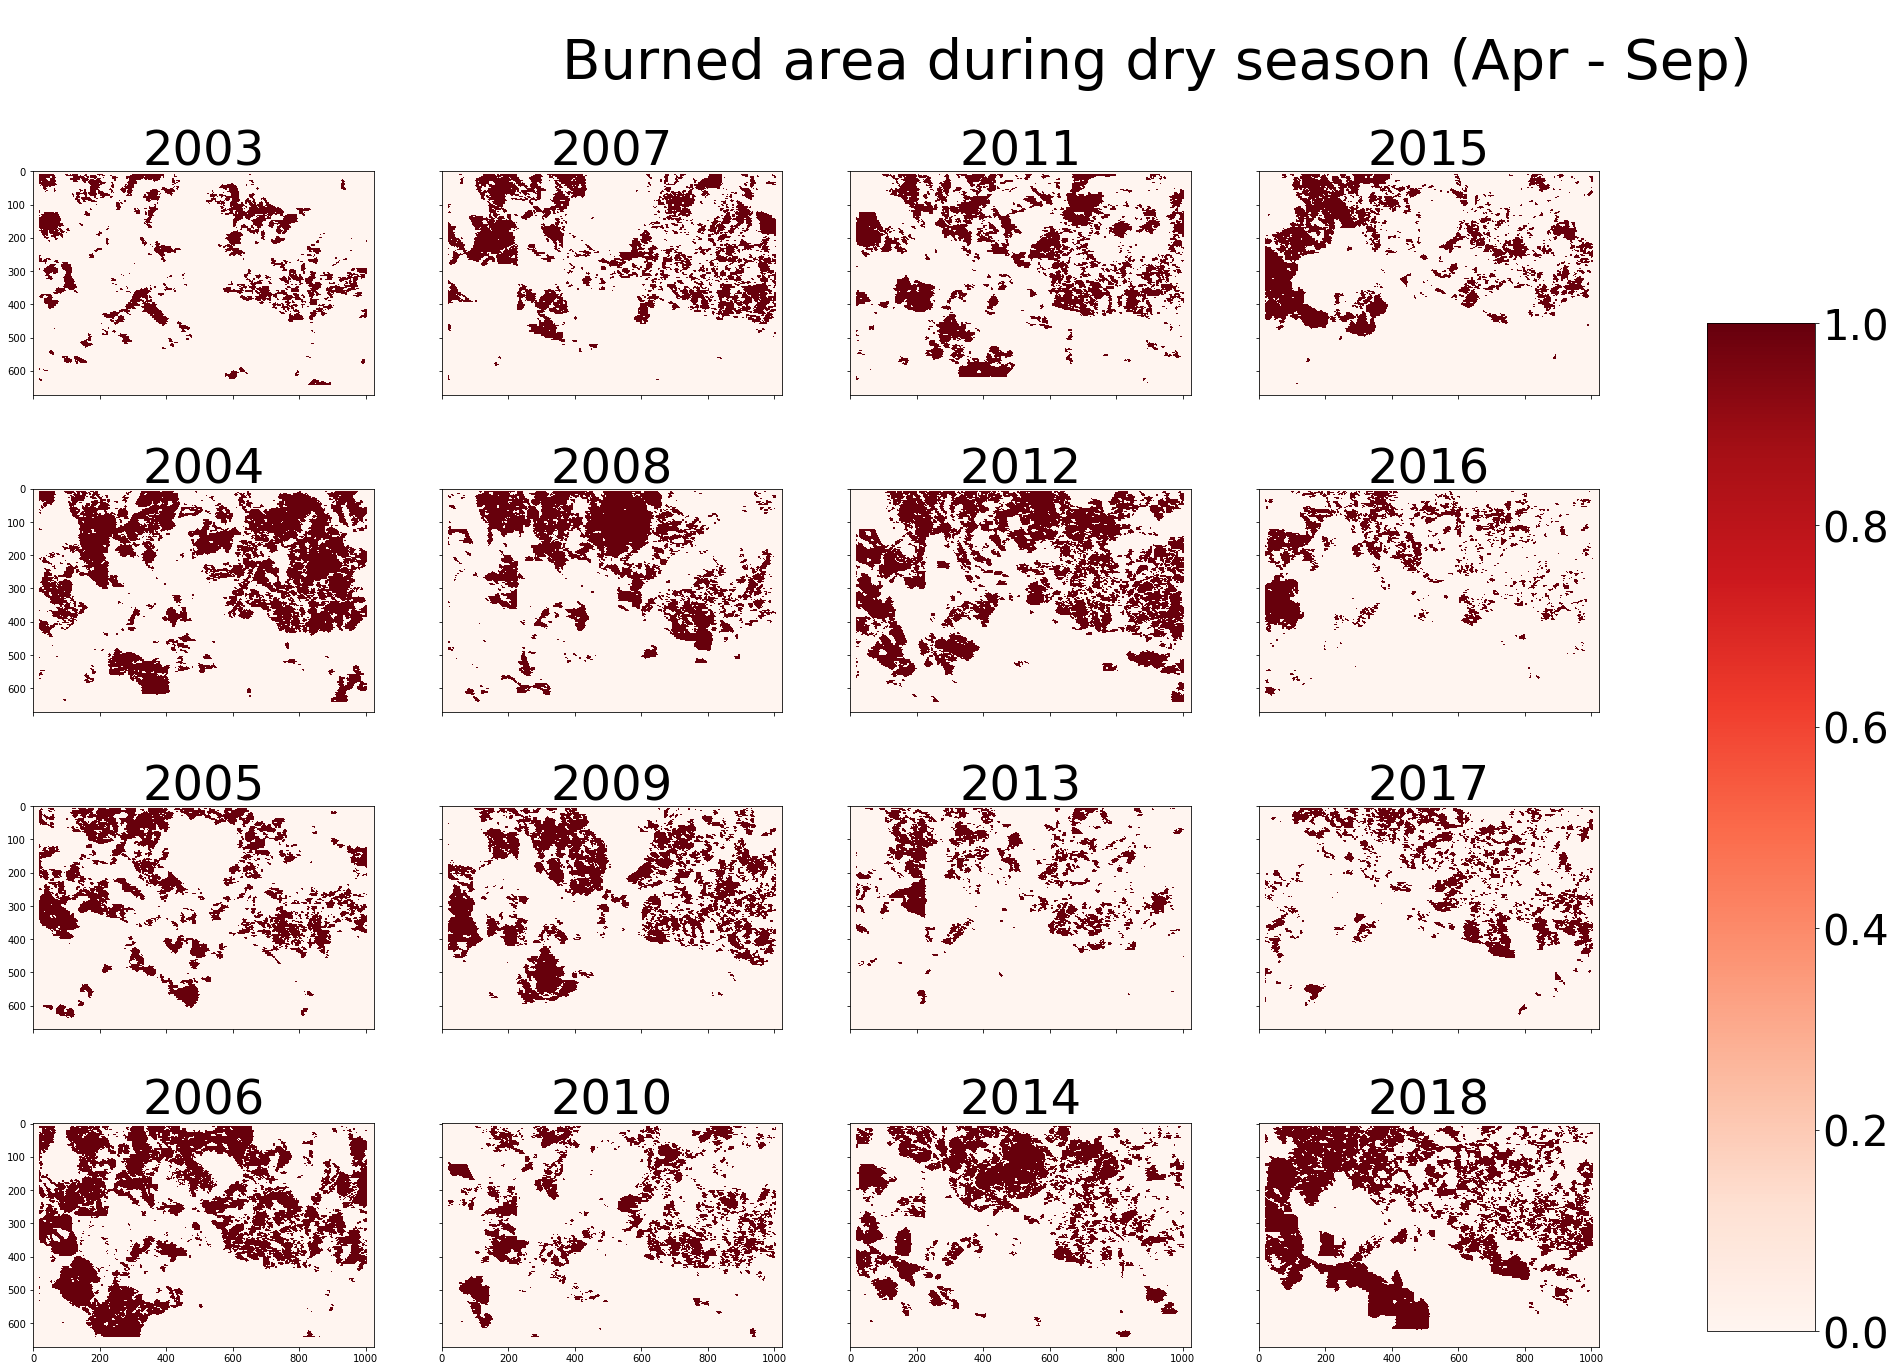

In [0]:
# PLOT BURNED AREA FOR EACH YEAR
# FOR BOTH SETS WE ARE SAMPLING 2003-2018 FIRE SEASONS
# 16 YEARS SO 4x4 PLOT
fig2, axs = plt.subplots(4, 4, sharey = 'row', sharex = 'col', figsize=(30,20))

for i in range(4):
  for j in range(4):
    k = j*4 + i
    im = axs[i][j].imshow(data_burn[k], vmin = 0, vmax = 1, cmap = 'Reds')
    start_year = year_list[k]
    # CENTRAL VIC DATASET
    #end_year = start_year + 1
    #ax_title = '{0} - {1}'.format(start_year, end_year)
    # NORTHERN TERRITORY DATASET
    ax_title = '{0}'.format(start_year)
    axs[i][j].set_title(ax_title, fontsize = 48)

fig2.subplots_adjust(top = 0.97, right=0.85)
cbar_ax = fig2.add_axes([0.9, 0.15, 0.05, 0.7])
cbar = fig2.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=42) 
title_ax = fig2.add_axes([0.37, 0.97, 0.4, 0.1])
# CENTRAL VIC DATASET 
#title_str = 'Burned area during summer (Dec - Mar)'
# NORTHERN TERRITORY DATASET 
title_str = 'Burned area during dry season (Apr - Sep)'
title_ax.axis('off')
title_ax.text(0, 0.5, title_str, transform= title_ax.transAxes, fontsize = 56)
plt.show()

VEGETATION PLOT

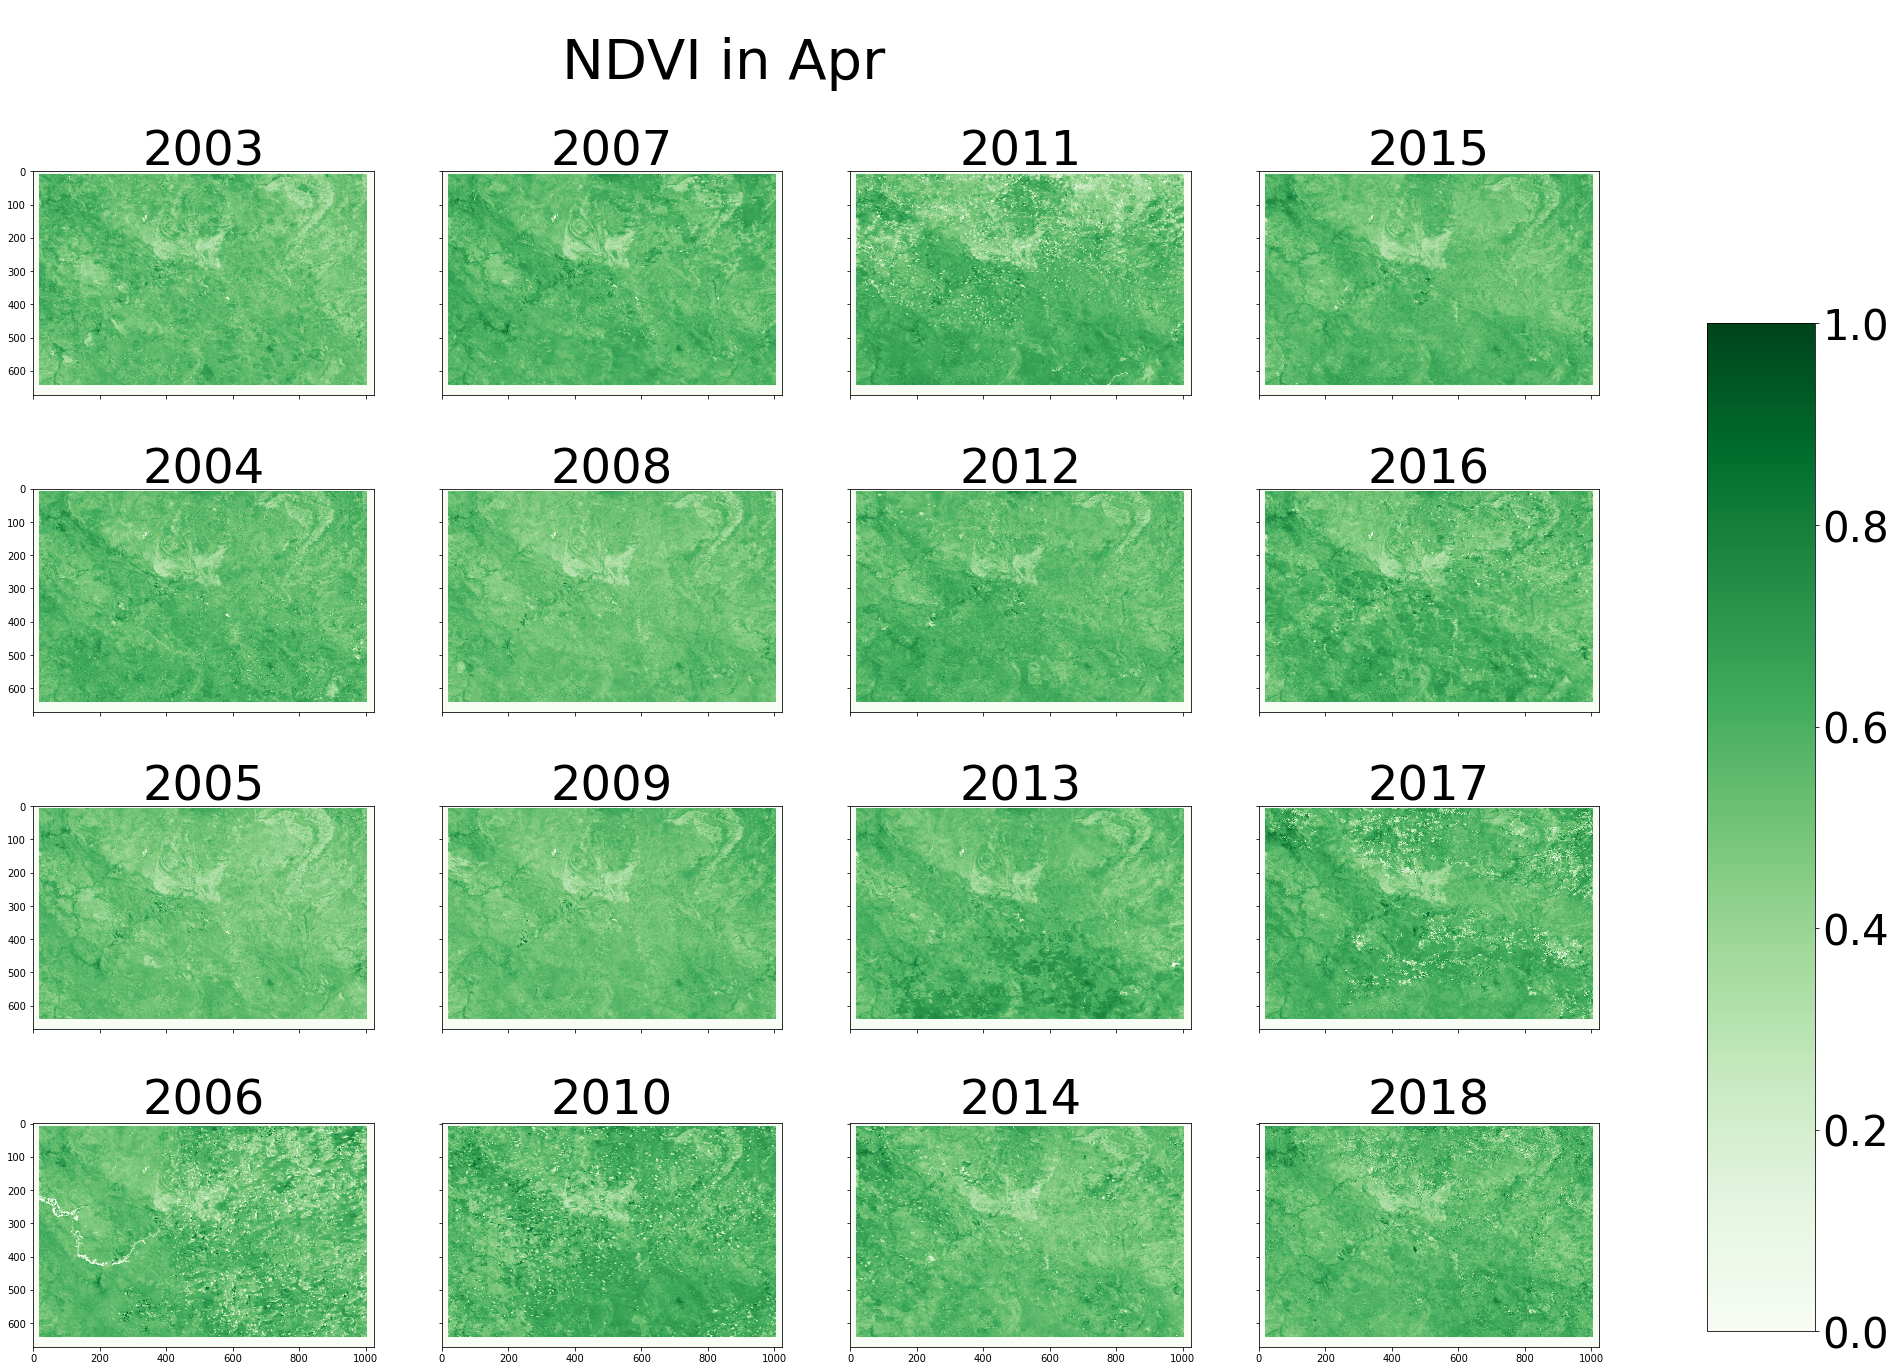

In [0]:
# PLOT NDVI FOR START OF SEASON EACH YEAR
# FOR BOTH SETS WE ARE SAMPLING 2003-2018 FIRE SEASONS
# 16 YEARS SO 4x4 PLOT
fig1, axs = plt.subplots(4, 4, sharey = 'row', sharex = 'col', figsize=(30,20))

for i in range(4):
  for j in range(4):
    k = j*4 + i
    im = axs[i][j].imshow(data_veg[k], vmin = 0 , vmax = 1, cmap = 'Greens')
    ax_title = '{0}'.format(year_list[k])
    axs[i][j].set_title(ax_title, fontsize = 48)

fig1.subplots_adjust(top = 0.97, right=0.85)
cbar_ax = fig1.add_axes([0.9, 0.15, 0.05, 0.7])
cbar = fig1.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=42) 
title_ax = fig1.add_axes([0.37, 0.97, 0.4, 0.1])
# CENTRAL VIC DATASET
#title_str = 'NDVI in Dec'
# NORTHERN TERRITORY DATASET
title_str = 'NDVI in Apr'
title_ax.axis('off')
title_ax.text(0, 0.5, title_str, transform= title_ax.transAxes, fontsize = 56)
plt.show()



TEST VISUALISATION!!!!!

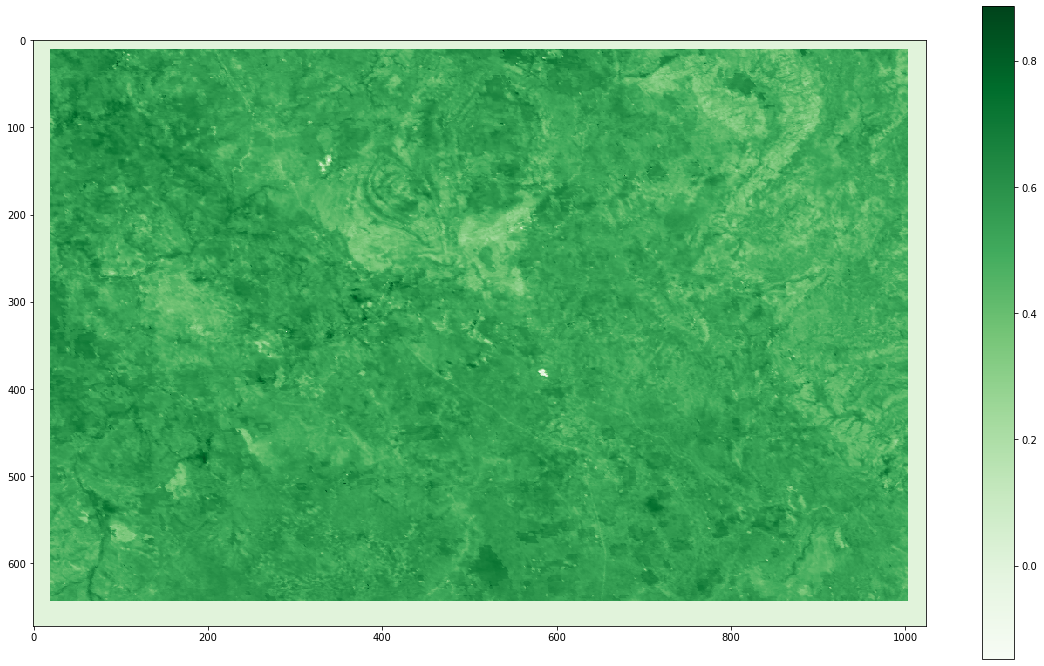

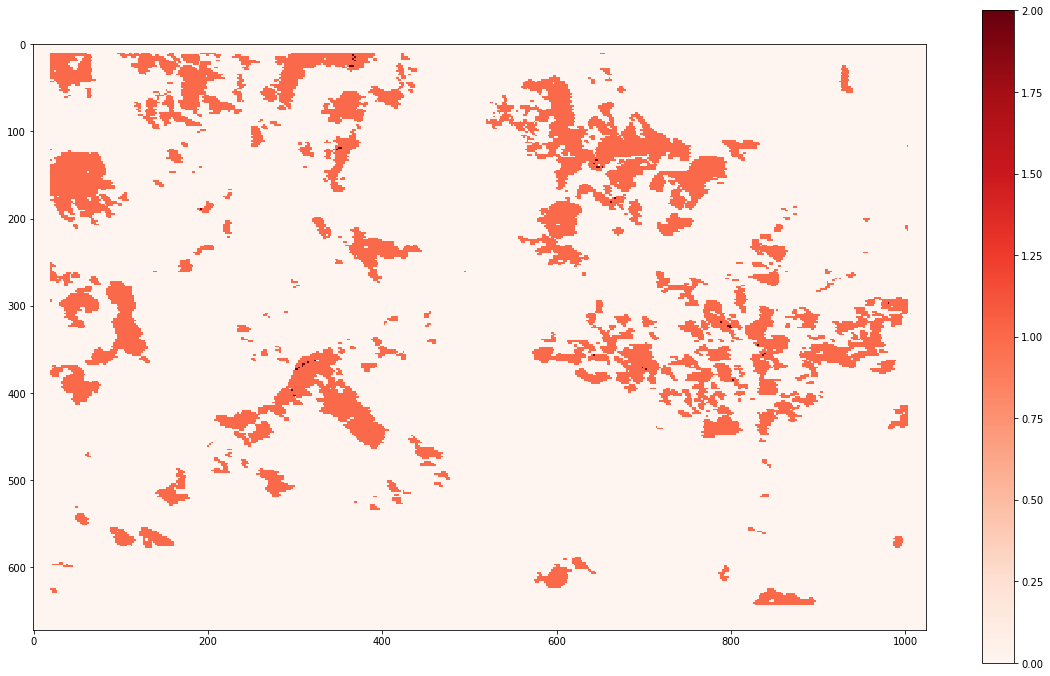

In [0]:
# print out one of the images
# Key = list(pairs_query.metadata.keys())[1]
# print(key)
plt.figure(figsize = (20, 12))
# plt.imshow(np.where(pairs_query.data[Key] == NO_DATA_VALUE, np.nan, pairs_query.data[Key]), cmap = 'Reds')
plt.imshow(vegetation_first, cmap = 'Greens')
plt.title('')
plt.colorbar()
plt.show()

plt.figure(figsize = (20, 12))
# plt.imshow(np.where(pairs_query.data[Key] == NO_DATA_VALUE, np.nan, pairs_query.data[Key]), cmap = 'Reds')
plt.imshow(burns_aggregated, cmap = 'Reds')
plt.title('')
plt.colorbar()
plt.show()